# Tutorial - Fault-Tolerant Quantum Computing with CSS codes

In this notebook we'll explore how fault-tolerant quantum computing looks like at the **circuit-level**.

For our exploration we'll introduce the *Steane Code*, proposed by Andrew Steane in 1996. It is a quantum code from the class of *Calderbank-Shor-Steane (CSS)* codes which was introduced in the lecture.

Our **goal** is to understand:
- How is a logical qubit prepared at the circuit-level?
- How can we implement logical gates between those logical qubits?
- How does the quantum error correction procedure looks like at the circuit-level? 

Let's explore the Steane code! 🔭

## Steane Code

The Steane code is a $[[7,1,3]]$ stabilizer code, which means that it encodes 7 physical qubits into 1 logical qubits. Its code distance is $d=3$, meaning that it will correct up to 
$$t = \lfloor 3 - 1 /2 \rfloor = 1$$
errors.

### Code Construction

**CSS codes:**

The class of Calderbank-Shor-Steane (CSS) codes provides a simple recipe of constructing quantum error correcting codes from classical *linear* codes.
In a linear $[n,k]$-code $C$, the code space is defined by the kernel of a parity check matrix $H \in \mathbb{Z}_2^{n - k \times n}$.

Meaning that for a code word $x \in \mathbb{Z}_2^n$, we must have:

$$Hx = 0.$$

Since we have to protect our quantum state from Pauli-$X$ and Pauli-$Z$ errors, CSS codes combine two classical linear codes $C_1$ and $C_2$. The respective parity check matrices $H_1$ and $H_2$ define the $X$ and $Z$ stabilizers. To emphasize this fact, we'll denote the matrices as $H_X$ and $H_Z$.

The rows of the parity check matrices define the stabilizer. 

> **Example:** If the $i$-th row of $H_X$ is given as $1001$ then the corresponding stabilizer is $X_1X_4 = X_1 \otimes I_2 \otimes I_3 \otimes X_4$.

Since all stabilizers from the same parity check matrix necessarily commute, we need to make sure that rows from $H_X$ and $H_Z$ commute. This is ensured if the number of qubits targeted by both stabilizer types is even for each possible pair of stabilizers.

> **Example:** $X_1X_2X_5X_6$ and $Z_1Z_2Z_3Z_4$ commute as they both target qubits 1 and 2 which is an even number of qubits.

**Parity Check Matrix:**

For the Steane code, we have $H_X = H_Z = H$ with

$$H = \begin{bmatrix}1 & 1 & 1 & 1 & 0 & 0 & 0\\0 & 1 & 1 & 0 & 1 & 1 & 0\\ 0 & 0 & 1 & 1 & 0 & 1 & 1\end{bmatrix}$$

**Stabilizers:**

We can now define the generators of the stabilizer group corresponding to the Steane code based on $H$:

$$S_X = \langle X_1X_2X_3X_4, X_2X_3X_5X_6, X_3X_4X_6X_7 \rangle$$
$$S_Z = \langle Z_1Z_2Z_3Z_4, Z_2Z_3Z_5Z_6, Z_3Z_4Z_6Z_7 \rangle$$

### Exercise 1
Given the stabilizers, write down a valid code state $|\psi \rangle = | \psi_1\rangle \otimes | \psi_2\rangle \otimes | \psi_3\rangle \otimes | \psi_4\rangle \otimes | \psi_5\rangle \otimes | \psi_6\rangle \otimes | \psi_7\rangle  $ of the Steane code.
 
As a reminder, a valid code state is the simultaneous Eigenstate of all stabilizers such that:
$$S|\psi\rangle = |\psi\rangle \;\;\; \forall S \in S_X \cup S_Z$$

> **Tip:** Any stabilizer can be decomposed into a product of generators. This means that only generators have to be considered when checking the stabilizing property.


### Visualizing the Steane Code

To think about the properties of quantum error correcting codes it is often beneficial to visualize them. In the picture below, the vertices represent the physical qubits. Each coloured face defines an $X$ and $Z$-type stabilizer.

![Steane Code Plaquettes](img/steane-code-stabilizers.png)

Putting the stabilizers together we get triangle with three faces also called *plaquettes* in the literature.



![Steane Code Lattice](img/steane-code-lattice.png)

Source: [Arthur Pesah's blog post on the stabilizer formalism](https://arthurpesah.me/blog/2023-01-31-stabilizer-formalism-1/).

### Excursion: Stim and Stabilizer formalism

To implement the Steane Code, we'll use Stim, a stabilizer simulator developed by Google, which is used for quantum error corection research.

We'll introduce the 3 most important objects, which are:
- `PauliString`: Representation of a Pauli string such as $X_1X_4$.
- `Tableau`: A table holding the current stabilizers of a circuit.
- `Circuit`: Representation of quantum circuit similar to Qiskit.

#### Pauli Strings

A Pauli string is an $n$-qubit operator formed by taking the tensor product of single-qubit Pauli operators:

$$P = P_1 \otimes P_2 \otimes \cdots \otimes P_n, \quad \text{where } P_i \in \{I, X, Z, Y\}$$

For example, a two-qubit Pauli string might be $P = X \otimes Y$, often written as $XY$. 

> **Note:** We usually omit the identity gates, by adding indices. For example, for $P = X \otimes I \otimes Y$ is written as $X_1Y_3$.

**Efficient Encoding of Pauli Strings in Software:**

Stim is designed to allow the simulation of very large stabilizer codes, so an efficient representation on a computer is crucial.
There are 4 different single-qubit Pauli operators, so 2 bits are required to represent them. Stim uses the following encoding:

$$
\begin{align*}
enc(I) &= 00 \\
enc(X) &= 10 \\
enc(Z) &= 01 \\
enc(Y) &= 11
\end{align*}
$$

This encoding is chosen to reflect the algebraic properties of Pauli operators, also called a [**group homomorphism**](https://en.wikipedia.org/wiki/Group_homomorphism): $enc : (G_1,\cdot) \rightarrow (\mathbb{Z}_2^2,\oplus)$. 

The first bit indicates the presence of an $X$ operation, while the second bit indicates a $Z$ operation. The $Y$ operator, can be decomposed into $X \cdot Z$ and has therefore both bits set to 1.

This enables multiplication of Pauli operators through simple bitwise operations. For two Pauli operators $A$ and $B$, their product (up to a global phase) is computed by:

$$enc(A \cdot B) = enc(A) \oplus enc(B)$$

where $\oplus$ represents bitwise XOR. For example:

$$
\begin{align*}
enc(X \cdot Y) &= enc(X) \oplus enc(Y) \\
&= 10 \oplus 11 \\
&= 01 \\
&= enc(Z)
\end{align*}
$$

This matches the algebraic relation $XY = iZ$ (ignoring the phase factor $i$).

Let's explore Stim's [`PauliString`](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md#stim.PauliString) API:

In [1]:
import stim

xx = stim.PauliString("+XX")
zz = stim.PauliString("+ZZ")

# Pauli strings can be multiplied
mul_res = xx * zz
print("Multiplication: XX * ZZ = ", mul_res)

# Pauli strings can be concatenated
add_res = xx + zz
print("Addition: XX + ZZ = ", add_res)

# We can check if 2 Pauli strings commute
print("XX and ZZ commute: ", xx.commutes(zz))

Multiplication: XX * ZZ =  -YY
Addition: XX + ZZ =  +XXZZ
XX and ZZ commute:  True


#### Tableau

A tableau is the foundation of efficient simulation of stabilizer circuits. That is circuits, only composed of Clifford gates, mapping Pauli operators to other Pauli operators.

> **Reminder:** a Clifford operator $C$, applied to a product of Pauli's $P$, maps it to $CPC^{\dagger}$ which is again a Pauli product.

During execution of a quantum circuit consisting only of Clifford gates, we only need to update the stabilizer generator Pauli strings by applying the update rule above. With our efficient encoding, this can be done very fast.

In [2]:
# Define a Tableau simulator
simulator = stim.TableauSimulator()

In [3]:
# Prepare GHZ state
simulator.h(0)
simulator.cx(0, 1)
simulator.cx(0, 2)
simulator.measure_many(0, 1, 2)

[False, False, False]

While it is important to understand how the Tableau works, Stim's Tableau is heavily optimized which increases it's complexity. A nice introduction on Tableau simulation is given by Aaronson and Gottesman in ["Improved Simulation of Stabilizer Circuits"](https://arxiv.org/pdf/quant-ph/0406196).

For now, we are happy that we can apply gates to the Tableau and obtain correct measurements.

#### Circuit

Stim allows us to also define quantum circuits with a API like Qiskit or Cirq. Below we create the same 3 qubit circuit preparing a GHZ state.

In [4]:
c = stim.Circuit()

c.append("H", 0)
c.append("CNOT", [0, 1, 0, 2])
c.append("M", [0, 1, 2])

We can print the circuit using the `diagram` method of `stim.Circuit`.

There are different options to print the circuit:
- `timeline-text`: ASCII diagram
- `timeline-svg`: SVG image
- `timeline-svg-html`: Resizable SVG image
- `timeline-3d-html`: A 3d model, in GLTF format embedded in HTML
- `timeslice-svg`: Prints circuit between "TICK" operations (more on that later)

In [5]:
c.diagram("timeline-text")

q0: -H-@-@-M:rec[0]-
       | |
q1: ---X-|-M:rec[1]-
         |
q2: -----X-M:rec[2]-

We can sample from the circuit by compiling a sampler

In [6]:
sampler = c.compile_sampler()
samples = sampler.sample(shots=10)

As expected roughly half of our measurements are $00$ and the other half is $11$

In [7]:
samples

array([[False, False, False],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [False, False, False],
       [ True,  True,  True],
       [False, False, False],
       [ True,  True,  True],
       [False, False, False],
       [False, False, False]])

We can also execute the circuit with a Tableau simulator:

In [8]:
# Reset all qubits
simulator.reset(0, 1, 2)
simulator.do(c)

In [9]:
# All measurements are stored in the measurement record of the Tableau simulator
simulator.current_measurement_record()[-3::] # [-3::] to get the last 3 measurements

[False, False, False]

### Logical Operators of the Steane Code

The Steane code has exactly 6 stabilizer generators, imposing independent constraints on the logical qubit state:
$$S|\psi\rangle = |\psi\rangle \;\;\; \forall S \in S_X \cup S_Z$$

Intuitively, this means that for $7$ qubits we have **1 degree of freedom** left, meaning that the Steane code encodes a single logical qubit.

> It can be [shown](https://arthurpesah.me/blog/2023-03-16-stabilizer-formalism-2/), that for $m$ stabilizers and $n$ qubits, the number of logical qubits is $k = n - m$.

Assuming, that we have found a logical operator $O_L$, then applying it to the logical qubit should result in another valid code state. 
We can express this condition as:

$$O_L\ket{\psi} = O_LS\ket{\psi} = \ket{\psi}$$

Therefore $O_LS$ must be a stabilizer and the following must hold

$$O_LSO_L^{\dagger} = \hat{S} \in S_X \cup S_Z$$

As a reminder, the stabilizer generators for the Steane code are
$$S_X = \langle X_1X_2X_3X_4, X_2X_3X_5X_6, X_3X_4X_6X_7 \rangle$$
$$S_Z = \langle Z_1Z_2Z_3Z_4, Z_2Z_3Z_5Z_6, Z_3Z_4Z_6Z_7 \rangle$$

We can see that the operators

$$X_L = X_5X_6X_7 \;\;\;\; Z_L = Z_5Z_6Z_7$$

satisfy the conditions above. We have found logical $X_L$ and $Z_L$ operators! 

> **Note:** Although it is custom to denote the Pauli string containing Pauli-$Z$ as $Z_L$, the naming is completely arbitrary. We only care about the algebraic properties of the operators.

#### Exercise 2

**(a)** Verify in Stim, that the logical operators map the set of generators to itself and that $X_L$ and $Z_L$ anti-commute.

In [10]:
from stim import PauliString

steane_stabilizer = [
    PauliString("XXXXIII"),
    PauliString("IXXIXXI"),
    PauliString("IIIXXXX"),
    PauliString("ZZZZIII"),
    PauliString("IZZIZZI"),
    PauliString("IIIZZZZ"),
]

log_x = PauliString("IIIIXXX")  # TODO
log_z = PauliString("IIIIZZZ")  # TODO

# A helper function to perform conjugation.
# For Pauli operators, since they are their own inverse (up to phase),
# we can compute: conjugate(S) = L * S * L.
def conjugate_with(operator, pauli):
    return operator * pauli * operator

# Conjugate the stabilizers one by one with the logical observables and compare the lists
conj_log_x = [conjugate_with(log_x, s) for s in steane_stabilizer]
conj_log_z = [conjugate_with(log_z, s) for s in steane_stabilizer]

print("Stabilizers conjugated by log_x:")
for s in conj_log_x:
    print(s)

print("\nStabilizers conjugated by log_z:")
for s in conj_log_z:
    print(s)
    

# --- Verify that conjugation maps stabilizers to stabilizers ---
# One way to do this is to compare the list (up to overall phase) with the original stabilizer set.
# We use the string representation of the Pauli strings for comparison.
orig_stabilizer_set = {str(s) for s in steane_stabilizer}
conj_log_x_set   = {str(s) for s in conj_log_x}
conj_log_z_set   = {str(s) for s in conj_log_z}

print("\nConjugated (by log_x) stabilizer strings equal the original generators:",
      conj_log_x_set == orig_stabilizer_set)
print("Conjugated (by log_z) stabilizer strings equal the original generators:",
      conj_log_z_set == orig_stabilizer_set)




# Logical operators anti-commute
# TODO
# --- Verify that logical operators anti-commute ---
# For Pauli operators, anti-commutation means: L_x * L_z == - (L_z * L_x)
prod1 = log_x * log_z
prod2 = log_z * log_x

print("\nlog_x * log_z =", prod1)
print("log_z * log_x =", prod2)

# Now check if they differ only by a minus sign.
anticommute = (prod1 == -prod2)
print("Logical operators anti-commute:", anticommute)

Stabilizers conjugated by log_x:
+XXXX___
+_XX_XX_
+___XXXX
+ZZZZ___
+_ZZ_ZZ_
-___ZZZZ

Stabilizers conjugated by log_z:
+XXXX___
+_XX_XX_
-___XXXX
+ZZZZ___
+_ZZ_ZZ_
+___ZZZZ

Conjugated (by log_x) stabilizer strings equal the original generators: False
Conjugated (by log_z) stabilizer strings equal the original generators: False

log_x * log_z = +i____YYY
log_z * log_x = -i____YYY
Logical operators anti-commute: True


**(b)** Applying a stabilizer to a logical qubit does not change its state. This means that logical observables form equivalence classes modulus the stabilizers. Use Stim to find equivalent logical observables 

![Steane Logical Co-Sets](img/steane-code-logical-cosets.png)

Source: [Arthur Pesah's blog post on the stabilizer formalism](https://arthurpesah.me/blog/2023-01-31-stabilizer-formalism-1/).

In [11]:
import itertools
# Part (b): Produce the equivalence class of a logical observable.
#
# The idea is: for any stabilizer S, the operator L and L*S
# act identically on the codespace. Thus, L*S is an equivalent
# logical observable to L.
#
# Here, we generate the full stabilizer group from the 6 independent generators.
# There are 2^6 = 64 elements in the group.
# why 2^6? Because we have 6 generators, and each generator can be included or not in the product.
# Are each stabilizer geneator commuting with each other? Yes, they are all commuting.
# ============================================================================

# Identity operator on 7 qubits.
identity = PauliString("IIIIIII")

# Generate all 2^6 combinations (each bit tells us whether to multiply by the corresponding generator)
stabilizer_group = set()
for bits in itertools.product([0, 1], repeat=len(steane_stabilizer)):# 2^6 = 64 combinations
    # Start with the identity.
    s_op = identity
    for include, gen in zip(bits, steane_stabilizer):
        if include:
            s_op = s_op * gen
    # Note: Two Pauli strings that differ only by a global ± sign are equivalent.
    # For our purpose, we record the string representation (which might show a '-' sign).
    stabilizer_group.add(str(s_op))

# Convert to a sorted list for display.
stabilizer_group = sorted(stabilizer_group)
print("Full stabilizer group (64 elements):")
for op in stabilizer_group:
    print(op)

# Now, form the equivalence class (coset) of the logical X operator.
# For every stabilizer S in the group, compute X_L * S.
equiv_log_x = set()
for s_str in stabilizer_group:
    # Create a PauliString instance from the stabilizer string.
    s = PauliString(s_str)
    equiv_operator = log_x * s
    # We use str() to collect a canonical representation.
    equiv_log_x.add(str(equiv_operator))

# For clarity, we sort and display the resulting equivalence class.
print("\nEquivalence class for the logical X operator (X_L * S for each S in the stabilizer group):")
for op in sorted(equiv_log_x):
    print(op)

# Similarly, one can compute the equivalence class for the logical Z operator:
equiv_log_z = set()
for s_str in stabilizer_group:
    s = PauliString(s_str)
    equiv_operator = log_z * s
    equiv_log_z.add(str(equiv_operator))

print("\nEquivalence class for the logical Z operator (Z_L * S for each S in the stabilizer group):")
for op in sorted(equiv_log_z):
    print(op)

# ============================================================================
# Note:
# Operators that differ only by an overall sign (e.g. "IIIIXXX" vs "-IIIIXXX") 
# are physically equivalent as observables. Here we list the string representations 
# with the sign intact.
# ============================================================================

Full stabilizer group (64 elements):
+XXXX___
+XXX_XXX
+XYY_YYX
+XZZ_ZZX
+X__XXX_
+X_____X
+YYYY___
+Y__YYY_
+ZXX_XXZ
+ZYY_YYZ
+ZZZZ___
+ZZZ_ZZZ
+Z__ZZZ_
+Z_____Z
+_XXX__X
+_XX_XX_
+_YYY__Y
+_YY_YY_
+_ZZZ__Z
+_ZZ_ZZ_
+___XXXX
+___YYYY
+___ZZZZ
+_______
+iXXXZYYY
+iXYYY__Z
+iXYYZXXY
+iX__YYYZ
+iYXXZYYX
+iYYYXZZZ
+iYYYZXXX
+iYZZXYYZ
+iZYYXZZY
+iZYYY__X
+iZZZXYYY
+iZ__YYYX
-XYYXZZ_
-XZZXYY_
-YXXYZZ_
-YXX_XXY
-YYY_YYY
-YZZYXX_
-YZZ_ZZY
-Y_____Y
-ZXXZYY_
-ZYYZXX_
-_XXYZZY
-_XXZYYZ
-_YYXZZX
-_YYZXXZ
-_ZZXYYX
-_ZZYXXY
-iXXXYZZZ
-iXZZYXXZ
-iXZZZ__Y
-iX__ZZZY
-iYXXX__Z
-iYZZZ__X
-iY__XXXZ
-iY__ZZZX
-iZXXX__Y
-iZXXYZZX
-iZZZYXXX
-iZ__XXXY

Equivalence class for the logical X operator (X_L * S for each S in the stabilizer group):
+XXXXXXX
+XXXYYYY
+XXXZZZZ
+XXX____
+XYYXYYX
+XYYYXXY
+XZZXZZX
+XZZZXXZ
+X__X__X
+X___XX_
+YXXYYYX
+YYYYXXX
+ZXXXXXZ
+ZXXZZZX
+ZYYXYYZ
+ZZZXZZZ
+ZZZZXXX
+Z__X__Z
+_XXXXX_
+_XX___X
+_YYXYY_
+_ZZXZZ_
+___X___
+____XXX
+iYYYZ___
+iYYY_ZZZ
+iYZZ_YYZ
+iY__ZYY_
+iZXXYYY_
+iZYY

**(c) - Pen & Paper**
The Steane code is a CSS code, meaning that logical Clifford gates can be performed *transversally*. Verify that $H_L = H^{\otimes 7}$ is a logical operator. Then show that it correspond to a logical Hadamard based on how it acts on $X_L$ and $Z_L$.

> **Note:** In the same manner it can be shown that $S_L = S^{\otimes 7}$ implement the logical $S_L$ operator.

# (c) Pen & Paper

**Claim 1:** The operator  
$$
H_L = H^{\otimes 7}
$$  
is a logical operator for the Steane code.

### Verification of Logical Operator Property

The Steane code is a CSS code with stabilizer generators split into two sets:
- **X-type stabilizers:**
  $$
  S_X = \langle X_1X_2X_3X_4,\; X_2X_3X_5X_6,\; X_3X_4X_6X_7 \rangle,
  $$
- **Z-type stabilizers:**
  $$
  S_Z = \langle Z_1Z_2Z_3Z_4,\; Z_2Z_3Z_5Z_6,\; Z_3Z_4Z_6Z_7 \rangle.
  $$

Recall that the Hadamard gate satisfies:
$$
HXH = Z \quad \text{and} \quad HZH = X.
$$  
Thus, applying $H$ transversally (i.e. on every qubit) maps $X$-type operators to $Z$-type operators and vice versa. For example, consider the $X$-type stabilizer
$$
S_X = X_1 X_2 X_3 X_4.
$$  
Then:
$$
H^{\otimes 7} S_X \left(H^{\otimes 7}\right)^\dagger 
= (H_1X_1H_1)(H_2X_2H_2)(H_3X_3H_3)(H_4X_4H_4)\prod_{j=5}^7 (H_j I H_j)
= Z_1 Z_2 Z_3 Z_4,
$$  
which is one of the $Z$-type stabilizers. Similarly, any $Z$-type stabilizer will be mapped to an $X$-type stabilizer. Therefore, for any stabilizer $S$ in 
$$
S_X \cup S_Z,
$$  
we have:
$$
H_L S H_L^\dagger \in S_X \cup S_Z.
$$  
This confirms that $H_L$ maps the stabilizer group to itself and is thus a valid logical operator.

---

**Claim 2:** The operator  
$$
H_L = H^{\otimes 7}
$$  
implements the logical Hadamard gate. 

### Verification via Action on Logical Operators

Assume the representative logical Pauli operators are chosen as:
$$
X_L = X_5X_6X_7 \quad \text{and} \quad Z_L = Z_5Z_6Z_7.
$$  
A logical Hadamard gate must swap the logical $X$ and $Z$ operators. Using the conjugation properties of the Hadamard:
$$
H X H = Z \quad \text{and} \quad H Z H = X,
$$  
we then have:
$$
H^{\otimes 7}\, X_L\, \left(H^{\otimes 7}\right)^\dagger 
= Z_5Z_6Z_7 = Z_L,
$$
and similarly,
$$
H^{\otimes 7}\, Z_L\, \left(H^{\otimes 7}\right)^\dagger 
= X_5X_6X_7 = X_L.
$$  
Thus, $H_L$ exchanges the logical operators exactly as required for a logical Hadamard gate:
- It sends $X_L$ to $Z_L$.
- It sends $Z_L$ to $X_L$.

> **Note:** Similarly, one can show that  
> $$
> S_L = S^{\otimes 7}
> $$
> implements the logical $S$ operator by verifying its action on the logical $X$ and $Z$ operators.

---

**Conclusion:**  
Transversal application of the Hadamard gate, $$H_L = H^{\otimes 7},$$ both preserves the stabilizer group and swaps the logical $X$ and $Z$ operators, thus implementing the logical Hadamard gate for the Steane code.

## Quantum Computing with Logical Qubits

### State Initialization

Quantum circuits usually expect their qubits to be initialized in state $\ket{0}$. Unfortunately, $\ket{0000000}$ is not a valid code state.

> **Question**: Which stabilizers do not stabilize this state?

Therefore, an important, but usually costly, part of QEC is the logical qubit initialization. A naive approach is to prepare the physical qubits in state $\ket{0}$ and measure all stabilizers.


> **Question:** How many entangling gates are needed to measure all stabilizers of the Steane code naively in sequence?


To allow for fault-tolerant preparation of the logical qubit, avoiding spreading of errors due to entangling gates, various efficient schemes have been developed.

In the following we provide code for a scheme proposed by [Goto](https://www.nature.com/articles/srep19578). 

The scheme requires 8 CNOT gates to prepare the state, followed by a measurement of $Z_L$ via 3 CNOT gates using an ancilla qubit. If the measured ancilla is in the state $|0\rangle$ then we succesfully prepared the state $|0\rangle_L$, otherwise we reset all qubits and repeat the procedure. 

In [12]:
def encoding_circuit(log_qb_idx: int = 0) -> stim.Circuit:
    """Encoding scheme proposed by Goto 2015:
        https://www.nature.com/articles/srep19578

    To prepare the logical Steane qubit in state |0>_L.
    The qubit index allows shifting the indices so that
    we can prepare multiple logical qubits.
    """
    c = stim.Circuit()
    # shift registers to target logical qubit with given index
    s = log_qb_idx * 8

    c.append("H", [s, 4 + s, 6 + s])
    c.append("CNOT", [s, 1 + s])
    c.append("CNOT", [4 + s, 5 + s])
    c.append("CNOT", [6 + s, 3 + s])
    c.append("CNOT", [6 + s, 5 + s])
    c.append("CNOT", [4 + s, 2 + s])
    c.append("CNOT", [0 + s, 3 + s])
    c.append("CNOT", [4 + s, 1 + s])
    c.append("CNOT", [3 + s, 2 + s])

    # Entangle with ancilla qubit and measure logical Pauli-Z
    c.append("CNOT", [1 + s, 7 + s])
    c.append("CNOT", [3 + s, 7 + s])
    c.append("CNOT", [5 + s, 7 + s])
    c.append("M", [7 + s])

    return c

The encoding circuit can be visualized in Stim by printing the `diagram`

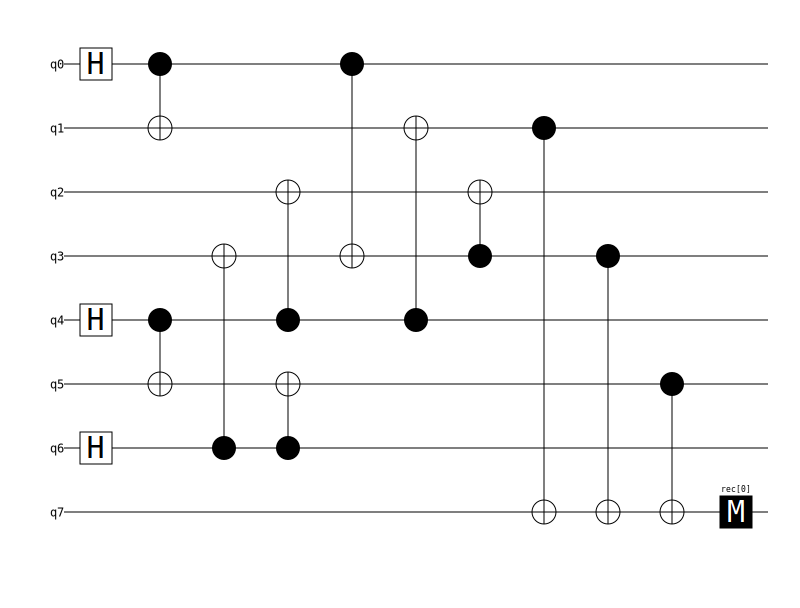

In [13]:
c = stim.Circuit()
c += encoding_circuit()
c.diagram("timeline-svg")

Given the encoding scheme, we should verify if it actually prepares a state with the correct stabilizers.

In [14]:
t = c.to_tableau(ignore_measurement=True)
print("Stabilizers")
t.to_stabilizers()

Stabilizers


[stim.PauliString("+XXXX____"),
 stim.PauliString("+ZZ__Z___"),
 stim.PauliString("+__ZZZ___"),
 stim.PauliString("+Z__Z__Z_"),
 stim.PauliString("+_XX_XX__"),
 stim.PauliString("+____ZZZ_"),
 stim.PauliString("+__XX_XX_"),
 stim.PauliString("+_Z_Z_Z_Z")]

# What Is the Tableau Doing Here?

In the provided code, the call to

$$
\texttt{t = c.to\_tableau(ignore\_measurement=True)}
$$

converts the circuit, defined by the function `encoding_circuit()`, into its *tableau representation*. Here's what that means in detail:

1. **Stabilizer Representation of Quantum States:**  
   In stabilizer formalism, a quantum state (typically one prepared in the all-$|0\rangle$ state) is described by a set of **stabilizer generators**. These generators form a group whose common +1 eigenspace is the state itself. Initially, for $n$ qubits, the state $|0\rangle^{\otimes n}$ is stabilized by the $Z$ operators on each qubit:
   $$
   \{Z_1, Z_2, \dots, Z_n\}.
   $$

2. **Circuit Operations Update the Stabilizers:**  
   When a quantum circuit composed of Clifford gates (like Hadamard and CNOT) is applied, the stabilizers are updated according to the conjugation rule:
   $$
   S \rightarrow g \, S \, g^\dagger,
   $$
   where $g$ is a gate from the circuit. This update process is efficiently tracked by the tableau.

3. **Encoding the Logical State:**  
   The encoding circuit (proposed by Goto) is designed to prepare the logical qubit $|0\rangle_L$ for the Steane code. The circuit uses a series of Hadamard and CNOT gates, followed by an entangling step with an ancilla qubit and measurement of the ancilla.  
   - The circuit first prepares the encoded state using **8 CNOT gates** (and a few Hadamard gates).
   - Then, it verifies the logical state by measuring $Z_L$ via **3 additional CNOT gates** with an ancilla qubit.
   - If the ancilla is measured to be in $|0\rangle$, the procedure is considered successful; otherwise, it is repeated.

4. **Role of `ignore_measurement=True`:**  
   By setting `ignore_measurement=True`, the tableau conversion disregards the effect of the measurement outcomes. This means the tableau reflects the *ideal* post-measurement state (assuming the measurement leads to successful verification). This is useful for understanding and verifying the encoding process regardless of the randomness inherent in measurement.

5. **Extracting and Verifying Stabilizers:**  
   After the circuit is converted to a tableau, the call
   $$
   \texttt{t.to\_stabilizers()}
   $$
   prints the list of stabilizer generators for the encoded state. This step allows you to verify that the encoding circuit has correctly set up the stabilizer group for the logical qubit, as expected for the Steane code.

---

**In summary:**  
The tableau here is the classical data structure that tracks the evolution of the stabilizer generators under the encoding circuit. It shows you the final stabilizer group that defines the logical state $|0\rangle_L$. This is how the code verifies—via the tableau's output—that the fault-tolerant encoding procedure (proposed by Goto) has correctly prepared the encoded state without spreading errors from the entangling gates.




The logical zero state \(|0\rangle_L\) of the Steane code is the unique state that is stabilized by all the Steane code’s stabilizer generators and has eigenvalue \(+1\) for the logical \(Z_L\) operator. In practice, this state is given by an equal superposition of the eight classical codewords of the underlying \([7,4,3]\) Hamming code.

In expanded form, one common way to write \(|0\rangle_L\) is


$|0\rangle_L = \frac{1}{\sqrt{8}} \Bigl( |0000000\rangle + |1010101\rangle + |0110011\rangle + |1100110\rangle + |0001111\rangle + |1011010\rangle + |0111100\rangle + |1101001\rangle \Bigr). $

Each 7-bit string here is a codeword that satisfies the parity-check conditions of the Hamming code. The normalization factor \(1/\sqrt{8}\) ensures that the state has unit norm. This superposition embodies the protection offered by the error-correcting code, because any single physical qubit error will move the state out of this specific subspace defined by these eight codewords. 

So, when the encoding circuit is applied (as described in Goto’s scheme), the goal is to prepare this logical zero state \(|0\rangle_L\) on the 7 physical qubits, ensuring that the resulting state is exactly this superposition.

We can see that the state prepared by the circuit is stabilized by 
$$X_1X_2X_3X_4,\;\;X_2X_3X_5X_6,\;\;X_3X_4X_6X_7$$

What about the Pauli-$Z$ stabilizers?

The [Goto scheme](https://www.nature.com/articles/srep19578), prepares the $|0\rangle_L$ state by measuring only the $Z$-stabilizers. Since arbitrary Pauli-$Z$ errors are in this case equivalent to no errors or single-qubit $Z$ errors which can be corrected by the Steane code.

As a final sanity check, we can sample shots from the circuit and measure $Z_L$. In the absence of noise, we should prepare the state $|0\rangle_L$ with 100% success rate.

To avoid code repetition, let's first define a method that takes a circuit, samples from it, and returns the measurements

In [155]:
import numpy as np


def measure_logical_qubits(log_qubit_indices: list[int] = [0]) -> stim.Circuit:
    c = stim.Circuit()

    for log_qubit_index in log_qubit_indices:
        # shift index
        s = log_qubit_index * 8
        # final measurement
        c.append("M", np.array([0, 1, 2, 3, 4, 5, 6]) + s)

    return c


def sample_from_circuit(c: stim.Circuit, shots: int = 10) -> np.array:
    # compile a sampler and sample 10 shots
    s = c.compile_sampler()
    r = s.sample(shots=shots).astype(int)

    return r

#### Exercise 3

Given the helper function above, complete the circuit above to correctly compute the logical $Z_L$ measurement result given the measurements of the physical qubits. 

In [156]:
c = stim.Circuit()
# prepare |0>_L
c += encoding_circuit()
# append final measurement
c += measure_logical_qubits()
# sample from circuit
r = sample_from_circuit(c, shots=10)
# compute Z_L observable from measurement
logical_measurement_output = None  # TODO

Note, that the first column of `r` corresponds to the ancilla qubit measurement and not the first qubit!

In [157]:
print("Logical measurement outcome: ", logical_measurement_output)

Logical measurement outcome:  None


As there is no noise, the ancilla should always be measured in state $|0\rangle$

In [158]:
print("Ancilla qubit measurement outcome: ", r[:, 0])

Ancilla qubit measurement outcome:  [0 0 0 0 0 0 0 0 0 0]


### Different Basis State Preparation

We can prepare the state $| 0 \rangle_L$ with the method above. Next, we'll want to prepare the logical qubit in different basis states

$$ \{ |0\rangle_L, |1\rangle_L, |+\rangle_L, |-\rangle_L, |+i\rangle_L, |-i\rangle_L \} $$

This can easily be done by using the logical gates $X_L, Z_L, S_L$, and $H_L$, that we identified in the previous section.

#### Exercise 4

Complete the lines marked with `TODO` in the function below (Always add the index shift `s` to prepare for operations on multiple logical qubits!)

In [159]:
def logical_single_qubit_gate(gate: str, log_qb_idx: int = 0) -> stim.Circuit:
    """
    Supported logical gates:
        - "Z": Logical Z gate
        - "X": Logical X gate
        - "H": Logical Hadamard gate
        - "S": Logical S (phase) gate

    Args:
        c (stim.Circuit): The stim object to append the logical gate to
        gate (str): The name of the logical gate to apply.
                    Must be one of: "Z", "X", "H", "S"
        log_qb_idx (int, optional): Index of the logical qubit to operate on.
                                    Used to offset the physical qubit indices
                                    when working with multiple logical qubits.
                                    Defaults to 0.
                                    Each logical qubit uses 8 physical qubits
                                    (7 data + 1 ancilla).

    Returns:
        stim.Circuit: The modified circuit with the logical gate appended
    """
    c = stim.Circuit()
    # shift registers to target logical qubit with given index
    s = log_qb_idx * 8

    match gate:
        case "Z":
            # TODO
            pass
        case "X":
            # TODO
            pass
        case "H":
            # TODO
            pass
        case "S":
            c.append("S", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case "S_DAG":
            c.append("S_DAG", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case _:
            raise ValueError("Logical gate name '{logical_gate}' undefined")

    return c

We define a helper function to prepare the logical qubit in the Eigenstate of a given Stabilizer

In [160]:
def prepare_stab_eigenstate(stabilizer: str) -> stim.Circuit:
    """Generates a circuit preparing the Eigenstate of a given singe-qubit stabilizer"""

    c = stim.Circuit()

    match stabilizer:
        case "+Z":  # |0>
            pass
        case "-Z":  # |1>
            c += logical_single_qubit_gate(gate="X")
        case "+X":  # |+>
            c += logical_single_qubit_gate(gate="H")
        case "-X":  # |->
            c += logical_single_qubit_gate(gate="X")
            c += logical_single_qubit_gate(gate="H")
        case "+Y":  # |+i>
            c += logical_single_qubit_gate(gate="H")
            c += logical_single_qubit_gate(gate="S")
        case "-Y":  # |-i>
            c += logical_single_qubit_gate(gate="X")
            c += logical_single_qubit_gate(gate="H")
            c += logical_single_qubit_gate(gate="S")
        case _:
            raise ValueError(f"Unknown stabilizer {stabilizer}")

    return c

Let's test the state preparation for our logical qubit when measuring in the $Z_L$ basis

In [161]:
c = stim.Circuit()
# prepare |0>_L
c += encoding_circuit()
# apply a bit-flip
c += logical_single_qubit_gate(gate="X")
# append final measurement
c += measure_logical_qubits()
# sample from circuit
r = sample_from_circuit(c, shots=10)

logical_measurement_output = r[:, 5] ^ r[:, 6] ^ r[:, 7]
print("Logical bit-flip measurement outcome: ", logical_measurement_output)

Logical bit-flip measurement outcome:  [0 0 0 0 0 0 0 0 0 0]


In [162]:
c = stim.Circuit()
# prepare |0>_L
c += encoding_circuit()
# apply a logical Hadamard gate
c += prepare_stab_eigenstate("-Z")
# append final measurement
c += measure_logical_qubits()
# sample from circuit
r = sample_from_circuit(c, shots=20)

# compute Z_L observable from measurement
logical_measurement_output = r[:, 5] ^ r[:, 6] ^ r[:, 7]
print("Logical Hadamard measurement outcome: ", logical_measurement_output)

Logical Hadamard measurement outcome:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [163]:
c = stim.Circuit()
# prepare |0>_L
c += encoding_circuit()
# apply a logical X by using logical HZH construction
c += logical_single_qubit_gate(gate="H")
c += logical_single_qubit_gate(gate="Z")
c += logical_single_qubit_gate(gate="H")
# append final measurement
c += measure_logical_qubits()
# sample from circuit
r = sample_from_circuit(c, shots=20)

# compute Z_L observable from measurement
logical_measurement_output = r[:, 5] ^ r[:, 6] ^ r[:, 7]
print("Logical bit-flip measurement outcome: ", logical_measurement_output)

Logical bit-flip measurement outcome:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Based on the results above, we can see that logical operators works as expected and that we prepare any state that we interested in.

### Measuring in different Basis

To measure a qubit in a different basis we usually apply single-qubit rotations before the measurement in the $Z$-basis. 

For example, if we want to measure in the $X$-basis we need to apply a Hadamard gate before the measurement since

$$\langle \psi | H Z H | \psi \rangle = \langle \psi | X | \psi \rangle $$

#### Exercise 5 

Complete the lines marked with `TODO` in the function below.

In [164]:
def rotate_to_measurement_basis(meas_basis: str) -> stim.Circuit:
    """Appends single-qubit rotations to a circuit to prepare
    measurement in specified basis"""
    c = stim.Circuit()

    match meas_basis:
        case "Z":
            pass
        case "X":
            # TODO
            pass
        case "Y":
            c += logical_single_qubit_gate(gate="S_DAG")
            c += logical_single_qubit_gate(gate="H")
        case _:
            raise ValueError("Specified target basis not known")

    return c

In [165]:
c = stim.Circuit()
# prepare |0>_L
c += encoding_circuit()
# rotate to X-basis
c += rotate_to_measurement_basis(meas_basis="X")
# append final measurement
c += measure_logical_qubits()
# sample from circuit
r = sample_from_circuit(c, shots=10)

# compute Z_L observable from measurement
logical_measurement_output = r[:, 5] ^ r[:, 6] ^ r[:, 7]
print("Logical bit-flip measurement outcome: ", logical_measurement_output)

Logical bit-flip measurement outcome:  [0 0 0 0 0 0 0 0 0 0]


### Transversal gates

We have now a good understanding of how to manipulate a single logical qubit. To leverage quantum advantage in the future, we will also need to be able to entangle our logical qubits. 

In this section we are going to implement a logical CNOT gate. Then, we'll put everything together to prepare a logical GHZ state using 14 + 2 physical qubits:
$$\ket{GHZ}_L = \frac{1}{\sqrt{2}}\left(\ket{00}_L + \ket{11}_L\right)$$

In a first step, we prepare the state $|0\rangle_L \otimes |0\rangle_L$

In [166]:
# prepare |0>_L x |0>_L
c = stim.Circuit()
c += encoding_circuit(log_qb_idx=0)
c += encoding_circuit(log_qb_idx=1)

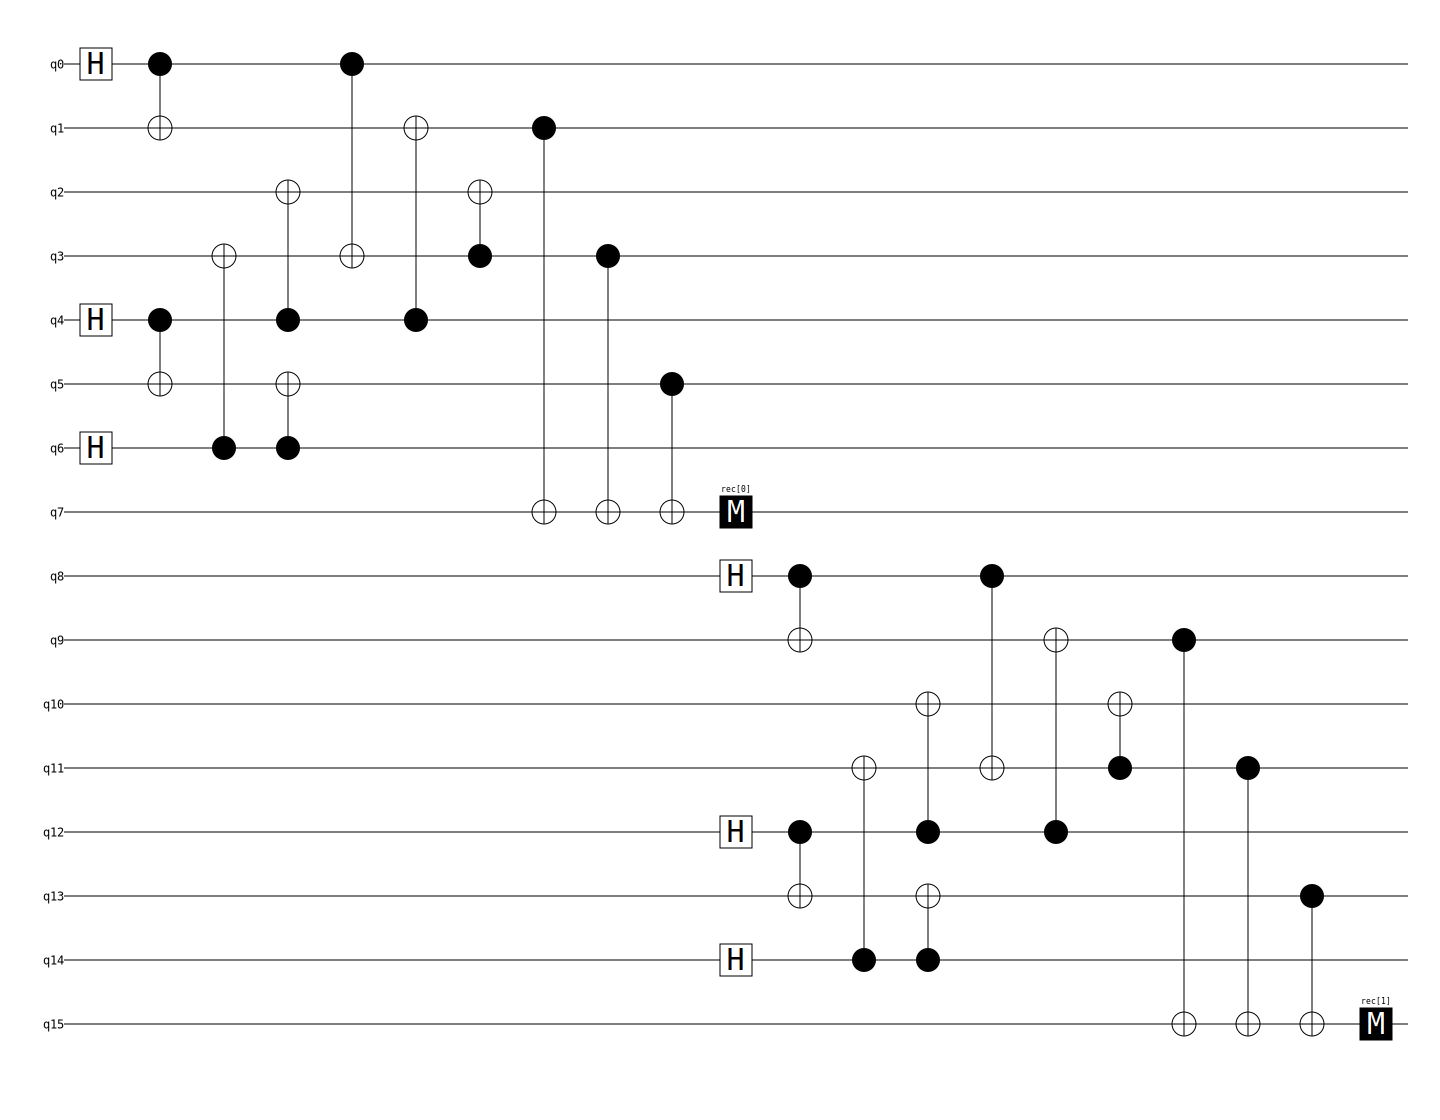

In [167]:
c.diagram("timeline-svg")

#### Logical CNOT Implementation

As shown in the lecture, CSS codes allow for transversal implementation of logical entangling gates such as the logical CNOT gate. 
In the Steane code the logical transversal CNOT gate is simply the pairwise CNOT between physical qubits at the same index of their respective logical qubit.  

Let's write a method that implements the logical CNOT:

In [168]:
def logical_cnot(ctrl_idx: int, target_idx: int) -> stim.Circuit:
    """Implement a transversal CNOT by applying CNOT between physical
    qubits of the logical qubits"""
    c = stim.Circuit()
    if ctrl_idx == target_idx:
        raise ValueError("Control index cannot be equal target index")

    offset_ctrl = ctrl_idx * 8
    offset_target = target_idx * 8

    for i in range(7):
        c.append("CNOT", [i + offset_ctrl, i + offset_target])

    return c

Before applying the logical CNOT, we flip the control logical qubit to be able to test our gate

In [169]:
c += logical_single_qubit_gate(gate="X")

In [170]:
c += logical_cnot(ctrl_idx=0, target_idx=1)

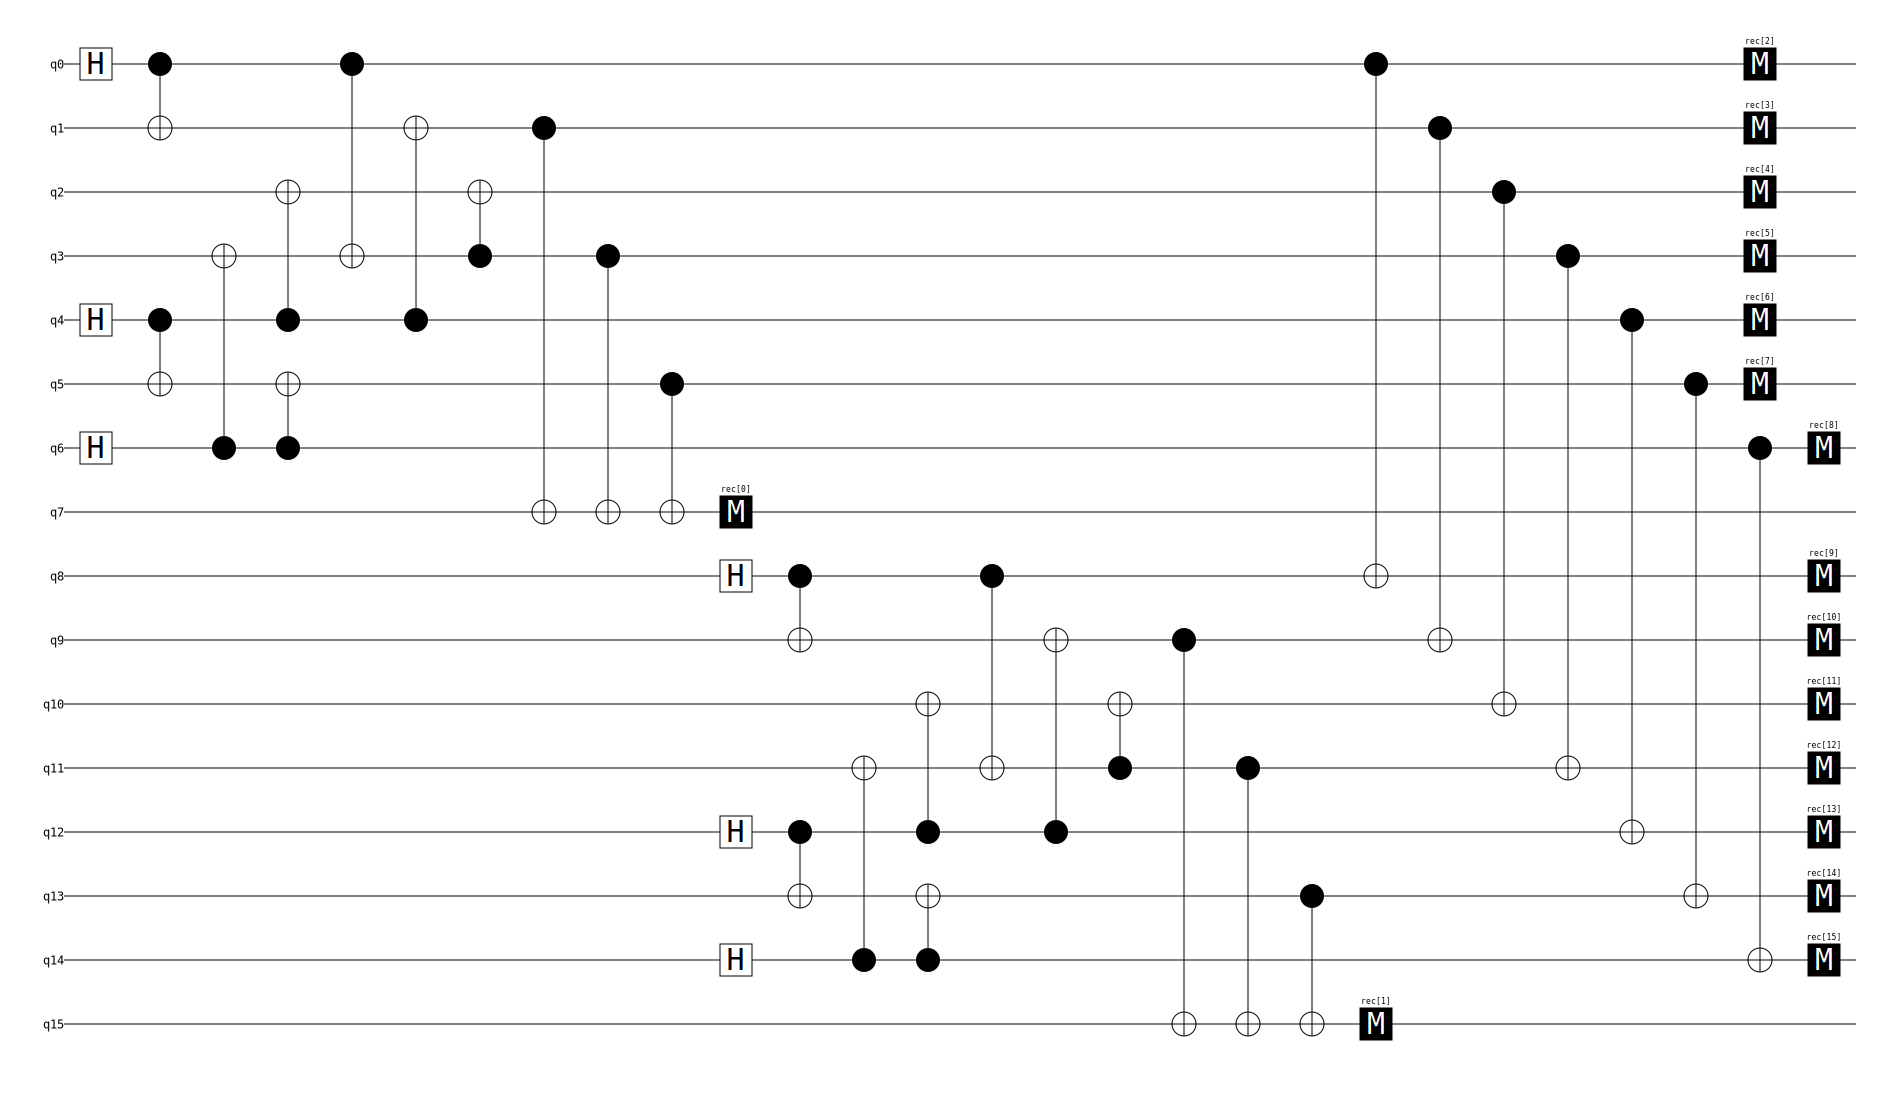

In [171]:
c += measure_logical_qubits(log_qubit_indices=[0, 1])
c.diagram("timeline-svg")

In [172]:
r = sample_from_circuit(c, shots=10)

In [173]:
logical_measurement_output_qb1 = r[:, 6] ^ r[:, 7] ^ r[:, 8]
logical_measurement_output_qb2 = r[:, 6 + 7] ^ r[:, 7 + 7] ^ r[:, 8 + 7]

In [174]:
print(logical_measurement_output_qb1)
print(logical_measurement_output_qb2)

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


### Logical Bell State

Now, we have all tools to implement a logical Bell state!

In [175]:
# prepare |0>_L x |0>_L
c = stim.Circuit()
c += encoding_circuit(log_qb_idx=0)
c += encoding_circuit(log_qb_idx=1)

# Apply Hadamard to first qubit
c += logical_single_qubit_gate(gate="H", log_qb_idx=0)
# Apply logical CNOT
c += logical_cnot(ctrl_idx=0, target_idx=1)

# Add final measurements
c += measure_logical_qubits(log_qubit_indices=[0, 1])

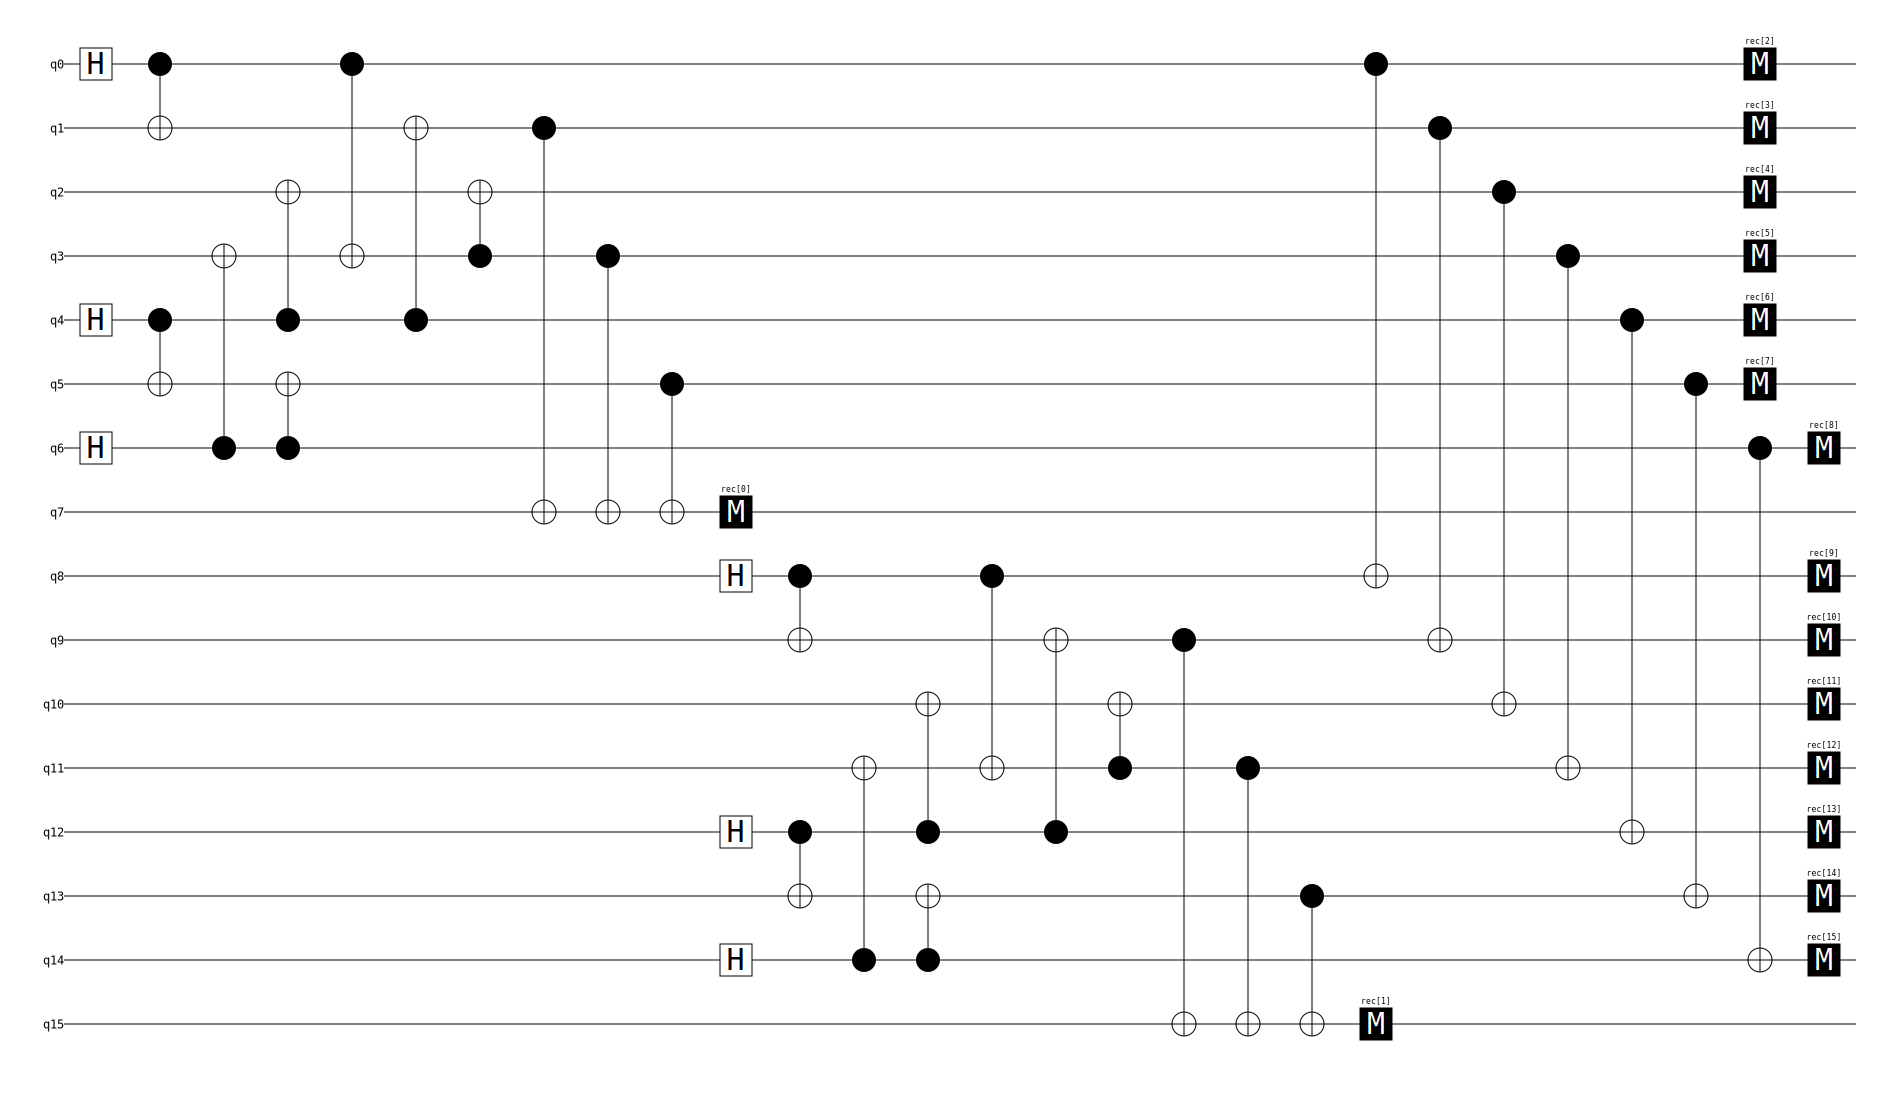

In [176]:
# Optionally display the circuit
c.diagram("timeline-svg")

In [177]:
# sample and extract states
r = sample_from_circuit(c, shots=20)

logical_measurement_output_qb1 = r[:, 6] ^ r[:, 7] ^ r[:, 8]
logical_measurement_output_qb2 = r[:, 6 + 7] ^ r[:, 7 + 7] ^ r[:, 8 + 7]

print(logical_measurement_output_qb1)
print(logical_measurement_output_qb2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Optional: Simulating the Steane Code on noisy Hardware: Quantinuum Experiment

The Steane code has been realized in various experiments:
- [Quantum computations on a topologically encoded qubit](https://www.science.org/doi/10.1126/science.1253742), 2014, Nigg et al.
- [Realization of Real-Time Fault-Tolerant Quantum Error Correction](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041058), 2021
- [Demonstration of logical qubits and repeated error correction with better-than-physical error rates](https://arxiv.org/html/2404.02280v1), 2024

In the following, we provide code to simulate parts of the experiment by Quantinuum in 2021, where they implemented a single logical qubit on their ion-trap device and applied multiple rounds of error correction to it.

This will hopefully give you a better understanding of how rounds of quantum error correction are actually implemented and how errors are handled. Please refer to the paper to learn more about the details of the experiment. Happy exploring!

### Introducing Errors

#### Quantinuum error parameters

In their experiment, Quantinuum measured various error sources for their ion-trap device. 

| Operation | Error Channel | Probability |
|---|---|---|
| Initilization | Bit flip | $1.66 \cdot 10^{-6}$ |
| Measurement |  Bit flip | $2.4 \cdot  10^{-3}$ |
| Single-qubit gate | Depolarizing | $7 \cdot 10^{-5}$ |
| Two-qubit gate | Depolarizing | $3.1 \cdot 10^{-3}$ |

**Note:** We excluded non-Pauli channels, such as leakage, as they cannot be handled by Stim.

Below, we define a helper function that allows us to inject the noise defined in the paper into our circuits: 

In [178]:
class NoiseModel:
    """Applies noise to quantum circuits.

    Adds depolarizing noise after 1 and 2-qubit gates, measurement errors,
    and initialization errors based on typical superconducting qubit parameters.
    """

    def __init__(self):
        self.init_error = 1.66 * 1e-6
        self.meas_error = 2.4 * 1e-3
        self.depolarize1 = 7 * 1e-5
        self.depolarize2 = 3.1 * 1e-3
        self.enabled = True

    def apply(self, c: stim.Circuit) -> stim.Circuit:
        if not self.enabled:
            return c

        cn = stim.Circuit()
        for op in c:
            if not op.name == "CX":
                cn.append(op)
                if op.name in ["H", "X", "Y", "S", "S_DAG"]:
                    cn.append("DEPOLARIZE1", op.targets_copy(), self.depolarize1)
                if op.name == "M":
                    cn.append("X_ERROR", op.targets_copy(), self.meas_error)
                if op.name == "R":
                    cn.append("X_ERROR", op.targets_copy(), self.init_error)

            else:
                targets = op.targets_copy()
                for i in range(0, len(targets), 2):
                    control = targets[i]
                    target = targets[i + 1]
                    cn.append("CX", [control, target])
                    cn.append("DEPOLARIZE2", [control, target], self.depolarize2)
        return cn

In [179]:
noise = NoiseModel()

### Faulty logical state preparation

To test our noise model, we apply it to the Goto scheme. We expect to see some state preparation failures.

In [180]:
c = stim.Circuit()
# prepare |0>_L
c += noise.apply(encoding_circuit())
# append final measurement
c += measure_logical_qubits()

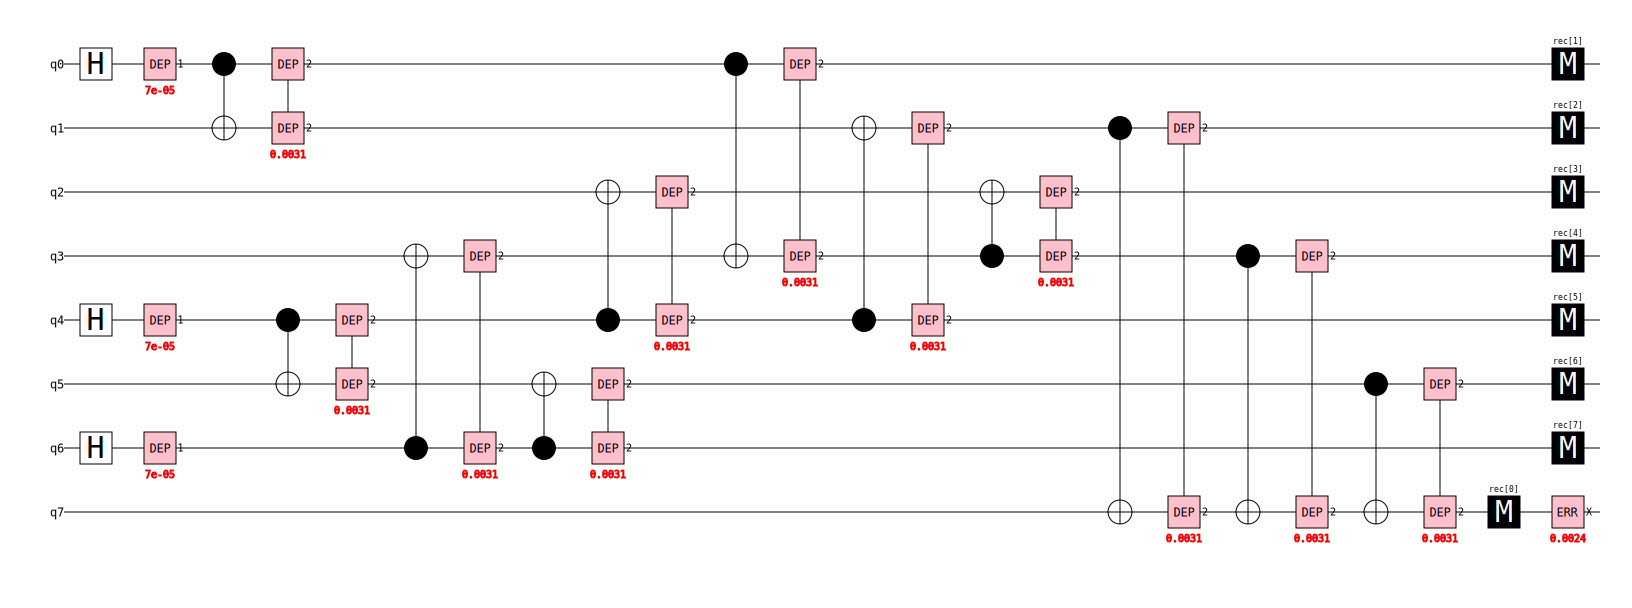

In [181]:
c.diagram("timeline-svg")

In [182]:
num_shots = 100_000
r = sample_from_circuit(c, shots=num_shots)

# compute Z_L observable from measurement
logical_measurement_output = r[:, 5] ^ r[:, 6] ^ r[:, 7]

In [183]:
# Measure how often the ancilla qubit is measured in state |0>
print("Success rate: ", (1 - (np.sum(r[:, 0]) / num_shots)) * 100, "%")

Success rate:  98.213 %


### Syndrome extraction

After succesful state preparation, the logical qubit is idling and the physical qubits will accumulate errors. This will cuase the logical qubit to decohere if we don't measure the stabilizers, effectively **digitizing the noise**, and tracking the changes in stabilizer measurements!

Below we first provide a function to measure all stabilizers of the code in a sequence.

In [184]:
def measure_all_syndromes() -> stim.Circuit:
    """Appends a circuit that measures all 6 stabilizers of the [[7,1,3]]-Steane code"""

    # indices for X-/Z-stabilizers
    syndrome_qubits = [
        [0, 1, 2, 3],  # 1st plaquette
        [1, 2, 4, 5],  # 2nd plaquette
        [2, 3, 5, 6],  # 3rd plaquette
    ]
    # indices for ancilla qubits
    ancilla_qubits = [8, 9, 10]

    c = stim.Circuit()
    # measure X-stabilizers
    for ancilla, data_qubits in zip(ancilla_qubits, syndrome_qubits):
        for data in data_qubits:
            c.append("CNOT", [data, ancilla])
        c.append("M", ancilla)
        c.append("R", ancilla)

    # measure Z-stabilizers
    for ancilla, data_qubits in zip(ancilla_qubits, syndrome_qubits):
        c.append("H", ancilla)
        for data in data_qubits:
            c.append("CNOT", [ancilla, data])
        c.append("H", ancilla)
        c.append("M", ancilla)
        c.append("R", ancilla)

    return c

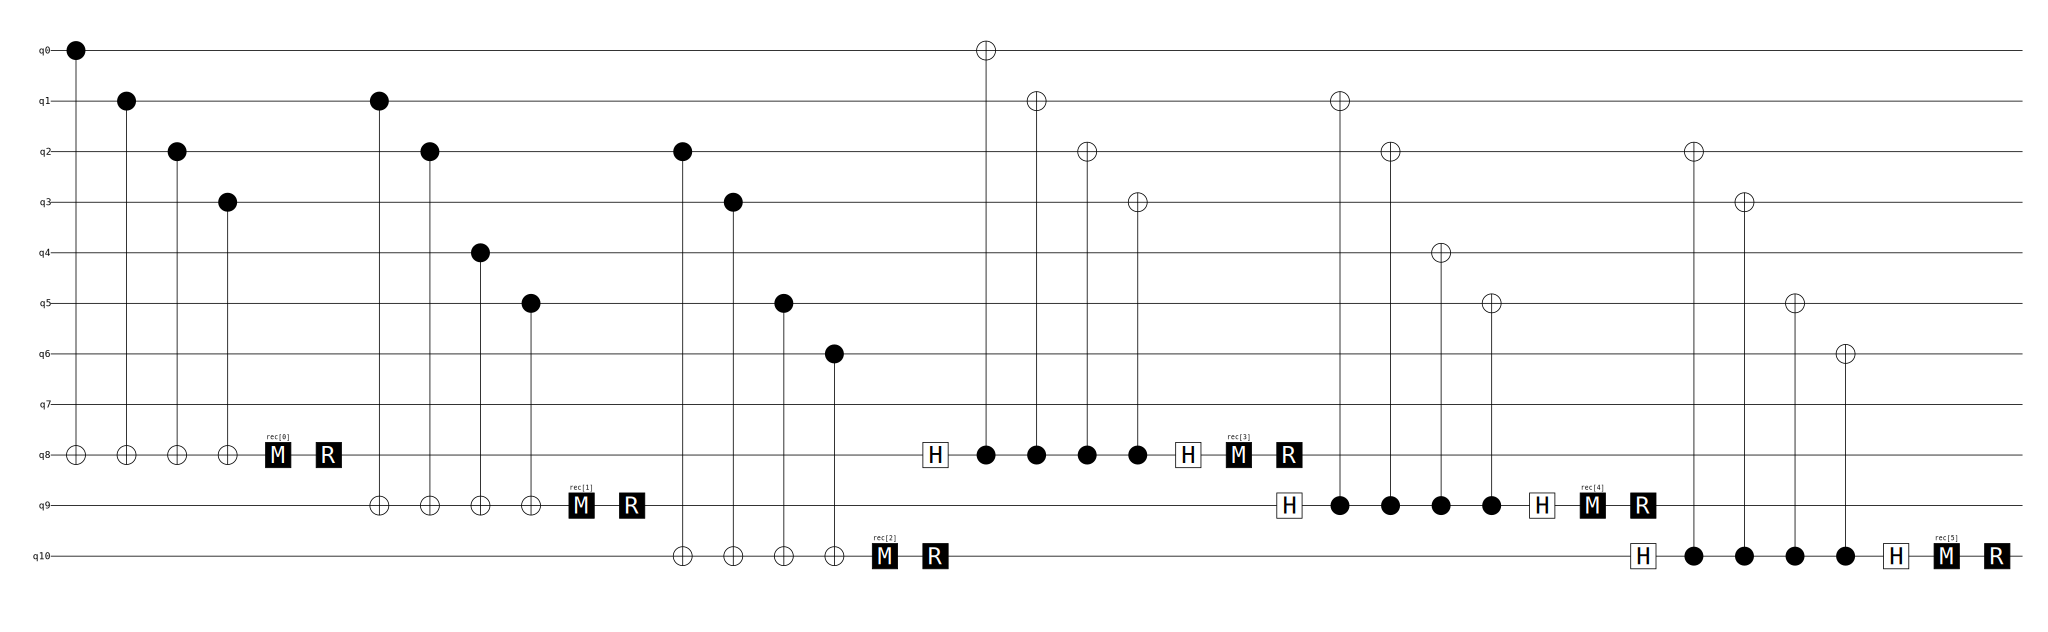

In [185]:
c = stim.Circuit()
c += measure_all_syndromes()
c.diagram("timeline-svg")

This approach for syndrome extraction is problematic as it is clearly not fault-tolerant. For example, consider a $Z$ error on one of the ancilla qubits. A single error can spread to 4 physical qubits during a single stabilizer measurement!

**Can we do better?**

A first approach could be to group the entangling gates, so that we measure the stabilizers in parallel. We can measure at most 3 stabilizers in parallel. This also reduces the time the physical qubits spent idling.

Furthermore, we need to consider the spreading of errors from the ancillas, so called **hook errors**. Since the Steane code is a distance $d=3$ code, we can at most correct a single error and detect two errors. 

A simple approach to detect hook errors is to add additional "flag" qubits, which measure parity checks on subsets of ancillas. In the following, we define circuits where the ancillas act themselves as flags for hook errors without the need for additional ancillas (Syndrome qubits reciprocally flag each other). 

In [186]:
def measure_flagged_syndromes_xzz() -> stim.Circuit:
    """Extracts flagged syndrome measurements for stabilizers 1, 5, 6

    1: XXXXIII  (Z errors on first plaquette)
    5: IZZIZZI  (X errors on second plaquette)
    6: IIZZIZZ  (X errors on third plaquette)
    """
    c = stim.Circuit()
    c.append("H", 8)
    c.append("CNOT", [8, 3])
    c.append("CNOT", [2, 10])
    c.append("CNOT", [5, 9])
    # correlate
    c.append("CNOT", [8, 9])
    c.append("CNOT", [8, 0])
    c.append("CNOT", [3, 10])
    c.append("CNOT", [4, 9])
    c.append("CNOT", [8, 1])
    c.append("CNOT", [6, 10])
    c.append("CNOT", [2, 9])
    # correlate
    c.append("CNOT", [8, 10])
    c.append("CNOT", [8, 2])
    c.append("CNOT", [5, 10])
    c.append("CNOT", [1, 9])
    c.append("H", 8)

    # measure ancillas and reset them
    c.append("M", [8, 9, 10])
    c.append("R", [8, 9, 10])
    return c

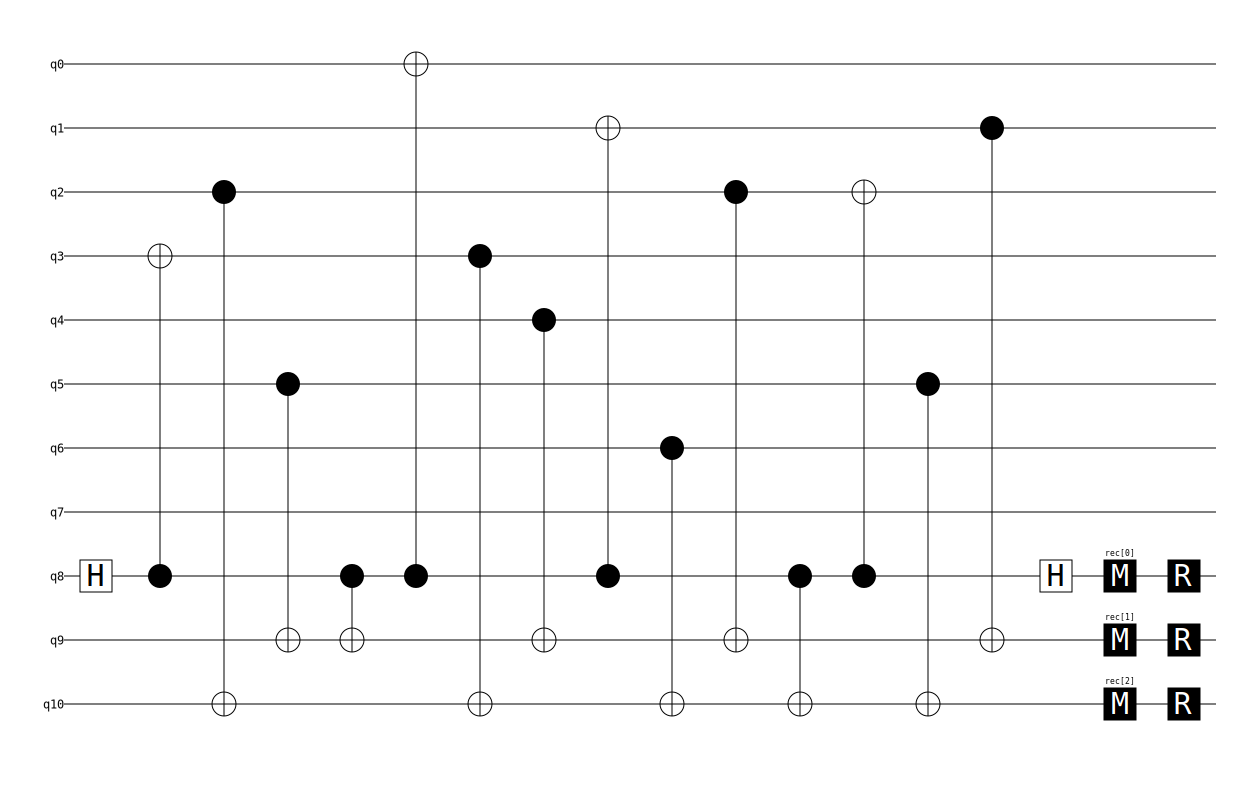

In [187]:
xzz = measure_flagged_syndromes_xzz()
xzz.diagram("timeline-svg")

In [188]:
def measure_flagged_syndromes_zxx() -> stim.Circuit:
    """Extracts flagged syndrome measurements for stabilizers 2, 3, 4

    2: ZZZZIII  (X errors on first plaquette)
    3: IXXIXXI  (Z errors on second plaquette)
    4: IIXXIXX  (Z errors on third plaquette)
    """
    c = stim.Circuit()

    c.append("H", [9, 10])
    c.append("CNOT", [3, 8])
    c.append("CNOT", [10, 2])
    c.append("CNOT", [9, 5])
    # correlate
    c.append("CNOT", [9, 8])
    c.append("CNOT", [0, 8])
    c.append("CNOT", [10, 3])
    c.append("CNOT", [9, 4])
    c.append("CNOT", [1, 8])
    c.append("CNOT", [10, 6])
    c.append("CNOT", [9, 2])
    # correlate
    c.append("CNOT", [10, 8])
    c.append("CNOT", [2, 8])
    c.append("CNOT", [10, 5])
    c.append("CNOT", [9, 1])
    c.append("H", [9, 10])

    # measure ancillas and reset them
    c.append("M", [8, 9, 10])
    c.append("R", [8, 9, 10])
    return c


An example of hook errors with flags is shown in the picture below, taken from the Quantinuum paper:

![Steane Hook Errors](img/quantinuum-steane-hook-errors.png)

### Full QEC cycle

We are nearly ready to run our full QEC cycle. We can now come up with a protocol to reliably correct a single physical qubit error. Our flagged syndrome circuits can detect hook errors. To differentiate them from heigher weight Pauli errors, we combine flagged and unflagged syndrome extraction.

If the flagged syndrome circuits do not indicate an error, than we are done and the next QEC cycle starts. Otherwise, we know that an error occurred, but we need to measure the complete set of stabilizers to identify whether a hook error occurred. 

This combination of conditional syndrome extraction is also known as **adaptive syndrome extraction** and can reduce average QEC cycle time significantly.

The adaptive QEC cycle is depicted in the picture below:

![](img/qec_cycle_with_flagged_syndromes.png)

Unfortunately, Stim does not support conditional circuit execution, which means that we need to drive the `TableauSimulator` manually.

In [189]:
# define a logger allowing us to print the progress of the execution of the QEC experiment
import logging

logging.basicConfig(format="%(message)s")

### The Decoder

The decoder is a simple two-stage **Lookup Table Decoder (LUT)**. This means that for each syndrome pattern there is a fixed rule on how to update the **Pauli Frame**, which indicates whether the logical qubit has been flipped or not.

The first stage is used to decode the unflagged syndromes and the second stage decodes the flagged syndromes.

$X$/$Z$-type errors are handled separately, but since the stabilizers have the same structure we can use the same LUT decoder.

> **Note:** We don't provide the syndromes directly to the decoder but only whether the syndromes changed between QEC cycle rounds.

In [190]:
def unflagged_decoder(syndromes: np.array) -> int:
    """Given X-/Z-type stabilizer measurements.

    The syndromes are used to infer whether a logical error has occurred

    This is exactly the case, when there is a change in syndromes
    for the 2nd/3rd stabilizer.
    """
    bad_syndrome_patterns = np.array([[0, 0, 1], [0, 1, 0], [0, 1, 1]])

    if np.any(np.all(bad_syndrome_patterns == syndromes, axis=1)):
        logging.debug("Unflagged decoder: Logical error detected!")
        return 1
    else:
        return 0


def flagged_decoder(syndromes: np.array, flagged_syndromes: np.array) -> int:
    """
    Handle hook errors.
    """

    if np.all(flagged_syndromes == [1, 0, 0]) and np.all(syndromes == [0, 1, 0]):
        return 1
    elif np.all(flagged_syndromes == [1, 0, 0]) and np.all(syndromes == [0, 0, 1]):
        return 1
    elif np.all(flagged_syndromes == [0, 1, 1]) and np.all(syndromes == [0, 0, 1]):
        return 1
    else:
        return 0


def decoder(syndromes: np.array, flagged_syndromes: np.array) -> list[int, int]:
    pf = unflagged_decoder(syndromes)
    pf_flag = flagged_decoder(syndromes, flagged_syndromes)

    return pf, pf_flag

In [191]:
def qec_cycle(
    simulator: stim.TableauSimulator,
    x_syndromes: np.array,
    z_syndromes: np.array,
    pauli_frame: np.array,
    m_idx: int,
    noise: NoiseModel,
) -> int:
    """Run a full QEC cycle for the [[7,1,3]]-Steane code
    by driving the Tableau simulator manually"""

    # track the delta of previous and current syndrome measurement
    flag_diff_x = np.array([0, 0, 0])  # track delta of X-stabilizers
    flag_diff_z = np.array([0, 0, 0])  # track delta of Z-stabilizers

    # first flagged syndrome extraction
    simulator.do(noise.apply(measure_flagged_syndromes_xzz()))
    # measure first X-stabilizer, and second/third Z-stabilizer
    fx0, fz1, fz2 = simulator.current_measurement_record()[m_idx : m_idx + 4]
    # update syndrome delta
    flag_diff_x[0] = fx0 ^ x_syndromes[0]
    flag_diff_z[1] = fz1 ^ z_syndromes[1]
    flag_diff_z[2] = fz2 ^ z_syndromes[2]
    # shift measurement index
    m_idx += 3
    # print delta for debugging
    logging.debug(
        f"Delta after 1st flagged measurement (XZZ): X {flag_diff_x}, Z {flag_diff_z}"
    )

    # if no syndrome changed continue with second round of flagged syndrome measurements
    if np.all(flag_diff_x == 0) and np.all(flag_diff_z == 0):
        # second flagged syndrome extraction
        simulator.do(noise.apply(measure_flagged_syndromes_zxx()))
        # measure first Z-stabilizer, and second/third X-stabilizer
        fz0, fx1, fx2 = simulator.current_measurement_record()[m_idx : m_idx + 4]
        # update syndrome delta
        flag_diff_z[0] = fz0 ^ z_syndromes[0]
        flag_diff_x[1] = fx1 ^ x_syndromes[1]
        flag_diff_x[2] = fx2 ^ x_syndromes[2]
        # shift measurement index
        m_idx += 3
        # print delta for debugging
        logging.debug(
            f"Delta after 2nd flagged measurement (ZXX): X {flag_diff_x}, Z {flag_diff_z}"
        )

    # re-measure all syndromes if flagged syndrome
    # extraction indicates changes in syndromes
    if np.any(flag_diff_z == 1) or np.any(flag_diff_x == 1):
        # run full syndrome extraction
        simulator.do(noise.apply(measure_all_syndromes()))
        s = simulator.current_measurement_record()[m_idx : m_idx + 7]
        # update syndromes
        current_z_syndromes = np.array(
            s[0:3], dtype=int
        )  # First 3 measurements Z-stabilizers
        current_x_syndromes = np.array(
            s[3::], dtype=int
        )  # Final 3 measurements X-stabilizers
        # compute delta
        diff_x_syndromes = x_syndromes ^ current_x_syndromes
        diff_z_syndromes = z_syndromes ^ current_z_syndromes
        # shift measurement index
        m_idx += 6
        # print new syndrome measurements
        logging.debug(
            f"Delta after unflagged measurement: "
            f"X:{diff_x_syndromes}, Z:{diff_z_syndromes}"
        )

        # call decoder to get updated pauli frame
        pf_x, pf_flag_x = decoder(diff_x_syndromes, flag_diff_x)
        pf_z, pf_flag_z = decoder(diff_z_syndromes, flag_diff_z)

        # update pauli frame
        pauli_frame[0] = pauli_frame[0] ^ pf_x ^ pf_flag_x
        pauli_frame[1] = pauli_frame[1] ^ pf_z ^ pf_flag_z
        logging.debug(f"Pauli frame: Z: {pauli_frame[0]}, X: {pauli_frame[1]}")

        # update syndromes
        x_syndromes = current_x_syndromes
        z_syndromes = current_z_syndromes

    return simulator, x_syndromes, z_syndromes, pauli_frame, m_idx

For the final round of quantum error correction, we measure all physical qubits simultaneously in the $Z$-basis.

Given the measurement results, we compute the syndrome measurements as well as the logical observable by classically XORing the bits.

Depending on the chosen measurement basis, we need to modify the syndromes.

In [192]:
def destructive_logical_measurement(
    simulator: stim.TableauSimulator,
    meas_basis: str,
    x_syndromes: np.array,
    z_syndromes: np.array,
    pauli_frame: np.array,
    m_idx: int,
    noise: NoiseModel,
) -> int:
    """Perform final destructive measurement where all physical qubits are measured.

    Returns a single bit, corresponding to the logical qubit measurement in the
    specified measurement basis. A final set of syndromes can be computed depending
    on the measurement basis.
    """

    # Measure all seven physical qubits of our logical qubit destructively
    simulator.do(noise.apply(measure_logical_qubits()))
    r = simulator.current_measurement_record()[m_idx : m_idx + 7]

    # Compute the logical observable
    log_obs = r[4] ^ r[5] ^ r[6]

    # Compute syndromes
    s1 = r[0] ^ r[1] ^ r[2] ^ r[3]  # First plaquette
    s2 = r[1] ^ r[2] ^ r[4] ^ r[5]  # Second plaquette
    s3 = r[2] ^ r[3] ^ r[5] ^ r[6]  # Third plaquette
    syndromes = np.array([s1, s2, s3], dtype=int)

    match meas_basis:
        case "X":
            syndrome_diff = syndromes ^ x_syndromes
        case "Y":
            syndrome_diff = syndromes ^ x_syndromes
            syndrome_diff = syndromes ^ z_syndromes
        case "Z":
            syndrome_diff = syndromes ^ z_syndromes
        case _:
            raise ValueError(f"Unknown measurement basis {meas_basis}!")

    logging.debug(f"Delta final round: {syndrome_diff}")

    # Get final corrections from the unflagged decoder
    final_correction = unflagged_decoder(syndrome_diff)

    # Update the logical obs
    log_obs = log_obs ^ final_correction

    # Finally, apply correction based on measurement basis
    match meas_basis:
        case "X":
            log_obs = log_obs ^ pauli_frame[0]
        case "Y":
            log_obs = log_obs ^ pauli_frame[0] ^ pauli_frame[1]
            logging.debug("log : %s, pf: %s", log_obs, pauli_frame)
        case "Z":
            log_obs = log_obs ^ pauli_frame[1]

    return log_obs

In [193]:
def expected_result(measure_output: int, stabilizer: str, meas_basis: str) -> int:
    """Evaluate if measurement corresponds to the expected measurement
    result for a given stabilizer and measurement basis."""

    pauli_measurement = stim.PauliString(meas_basis)
    pauli_stabilizer = stim.PauliString(stabilizer)
    commute = pauli_stabilizer.commutes(pauli_measurement)

    if not commute:
        raise ValueError("Anti-commuting stabilzers, measurement is random")

    sign = (pauli_measurement * pauli_stabilizer).sign

    if sign == 1:
        return int(0 == measure_output)
    else:
        return int(1 == measure_output)

Finally, we can put everything together and run the whole QEC cycle!

In [194]:
def steane_code_exp(
    initial_state: str = "+Z",
    meas_basis: str = "Z",
    num_cycles: int = 1,
    shots: int = 100,
    noise=NoiseModel(),
):
    """Runs an error correction experiment for the Steane [[7,1,3]]-code.

    The quantum state is represented by the state of the stim TableauSimulator.
    """
    results = []

    for _ in range(shots):
        simulator = stim.TableauSimulator()

        m_idx = 0  # shift measurement index

        # state preparation (3 attempts)
        # prepare the logical |0>_L state and verify with ancilla
        for _ in range(3):
            simulator.do(noise.apply(encoding_circuit()))
            state_prep_ancilla = simulator.current_measurement_record()[m_idx]
            logging.debug("State preparation ancilla: %s", int(state_prep_ancilla))
            m_idx += 1
            if not state_prep_ancilla:
                break

        # apply single qubit gate to prepare correct state
        simulator.do(noise.apply(prepare_stab_eigenstate(initial_state)))

        # run QEC cycles
        x_syndromes = np.array([0, 0, 0])
        z_syndromes = np.array([0, 0, 0])
        # Pauli frame tracks which logical correction to apply
        # Pauli Frame = [Apply X_L?, Apply Z_L?]
        pauli_frame = np.array([0, 0])

        for i in range(num_cycles):
            logging.debug(f"--- QEC cycle {i}")
            simulator, x_syndromes, z_syndromes, pauli_frame, m_idx = qec_cycle(
                simulator, x_syndromes, z_syndromes, pauli_frame, m_idx, noise
            )

        # Rotate to correct logical measurement basis
        simulator.do(noise.apply(rotate_to_measurement_basis(meas_basis=meas_basis)))

        # Perform final destructive logical measurement
        final_measurement = destructive_logical_measurement(
            simulator, meas_basis, x_syndromes, z_syndromes, pauli_frame, m_idx, noise
        )

        logging.debug(f"Final measurement: {final_measurement}")

        success = expected_result(final_measurement, initial_state, meas_basis)
        logging.debug(f"Success: {success}\n")
        results.append(success)

    return results

In [ ]:
# Uncomment to follow QEC cycle execution
logging.getLogger().setLevel(logging.DEBUG)

noise = NoiseModel()
noise.enabled = False

steane_code_exp(num_cycles=3, shots=1, initial_state="+Y", meas_basis="Y", noise=noise)

State preparation ancilla: 0
--- QEC cycle 0
Delta after 1st flagged measurement (XZZ): X [0 0 0], Z [0 0 0]
Delta after 2nd flagged measurement (ZXX): X [0 0 0], Z [0 0 0]
--- QEC cycle 1
Delta after 1st flagged measurement (XZZ): X [0 0 0], Z [0 0 0]
Delta after 2nd flagged measurement (ZXX): X [0 0 0], Z [0 0 0]
--- QEC cycle 2
Delta after 1st flagged measurement (XZZ): X [0 0 0], Z [0 0 0]
Delta after 2nd flagged measurement (ZXX): X [0 0 0], Z [0 0 0]
Delta final round: [0 0 0]
log : 0, pf: [0 0]
Final measurement: 0
Success: 1



[1]

: 

### Simulating Logical Error Rates for Steane Code for each Basis

In [ ]:
shots = 20 #2048
cycles_sweep = [0, 1, 2, 3, 4, 5, 6]
basis_sweep = ["Z", "X", "Y"]
noise = NoiseModel()
noise.enabled = True

results = []
for basis in basis_sweep:
    cycle_results = []
    for cycles in cycles_sweep:
        exp_results = steane_code_exp(
            num_cycles=cycles,
            shots=shots,
            initial_state=f"+{basis}",
            meas_basis=f"{basis}",
            noise=noise,
        )
        cycle_results.append(np.sum(exp_results) / shots)
    results.append(cycle_results)

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Success: 1

State preparation ancilla: 1
State preparation ancilla: 0
Delta final round: [1 0 0]
Final measurement: 1
Success: 0

State preparation ancilla: 0
Delta final round: [0 0 0]
Final measurement: 0
Succ

matplotlib data path: d:\anaconda3\envs\QEC\Lib\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\18084\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\18084\.matplotlib
Using fontManager instance from C:\Users\18084\.matplotlib\fontlist-v390.json
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='d:\\anaconda3\\envs\\QEC\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='d:\\anaconda3\\envs\\QEC\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', si

vmin 0.047327541132007996 vmax 0.1584700962824307
ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
vmin 0.047327541132007996 vmax 0.1584700962824307
ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01])
vmin 0.047327541132007996 vmax 0.1584700962824307
ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
vmin 0.047327541132007996 vmax 0.1584700962824307
ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])
vmin 0.047327541132007996 vmax 0.1584700962824307
ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 

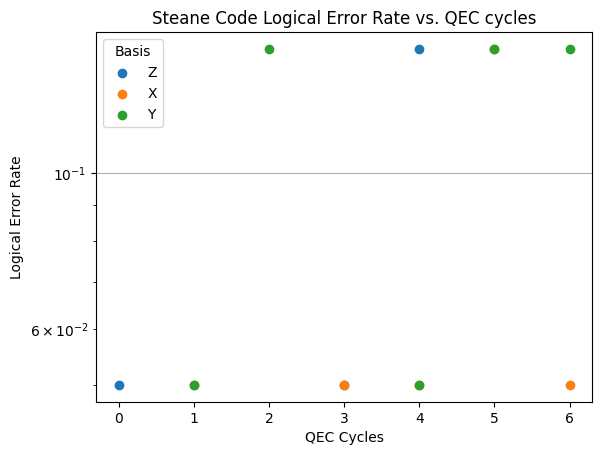

In [ ]:
import matplotlib.pyplot as plt

plt.title("Steane Code Logical Error Rate vs. QEC cycles")
plt.xlabel("QEC Cycles")
plt.ylabel("Logical Error Rate")
plt.grid(axis="y")
plt.yscale("log")
for idx, basis in enumerate(basis_sweep):
    plt.scatter(cycles_sweep, 1 - np.array(results[idx]), label=basis)
plt.legend(title="Basis")